In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB


## Data Cleaning and Processing

In [35]:
# Return me the 'ts' for each column where the first not NaN value per column occurs
starting_times = data.loc[data.notnull().idxmax(), 'ts']
starting_times

NameError: name 'data' is not defined

In [2]:
# Load all CSV files
network_manager = pd.read_csv('Data/Bornholm Network Manager.csv', delimiter=';')
nordpool_price = pd.read_csv('Data/NordPool.csv', delimiter=';')
weather_forecast = pd.read_csv('Data/Norwegian.csv', delimiter=';')
weather_observation = pd.read_csv('Data/Weather Observation.csv', delimiter=';')
energinet_price = pd.read_csv('Data/Energinet Balance price.csv', delimiter=';')

# Filter the Energinet data to only include zone DK2
energinet_price = energinet_price[energinet_price['PriceArea | PriceArea | 804696'] == 'DK2']

# Convert the 'ts' column to datetime format for each dataset
network_manager['ts'] = pd.to_datetime(network_manager['ts'], dayfirst=True) 
#columns: Voltage, Active Power, Current
nordpool_price['ts'] = pd.to_datetime(nordpool_price['ts'], dayfirst=True) 
#columns: hourly price (DKK/€); daily average price (DKK/€) -> missing on purpose?  
weather_forecast['ts'] = pd.to_datetime(weather_forecast['ts'], dayfirst=True) 
#columns: wind direction, wind speed, wind speed (y), wind speed (x) (choose only one location!); air temp, min/max air temp (6h), precipitation (1h), humidity,  -> missing on purpose?
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'], dayfirst=True) 
#columns: mean wind direction, mean wind speed, mean temp; precipitation, humidity, max+min temp, intensity of global radiation, -> missing on purpose (choose only one location!)
energinet_price['ts'] = pd.to_datetime(energinet_price['ts'], dayfirst=True) 
#columns: € or DKK?

# Set 'ts' as the index for each DataFrame
network_manager.set_index('ts', inplace=True)
nordpool_price.set_index('ts', inplace=True)
weather_forecast.set_index('ts', inplace=True)
weather_observation.set_index('ts', inplace=True)
energinet_price.set_index('ts', inplace=True)

# Resample network_manager data to hourly intervals (average the data)
network_manager_hourly = network_manager.resample('H').mean()

# Reset the index to bring 'ts' back as a regular column for merging
network_manager_hourly.reset_index(inplace=True)

C:\Users\konst\AppData\Local\Temp\ipykernel_53100\986287135.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network_manager_hourly = network_manager.resample('H').mean()


#### Data Visualization

**Network Manager**

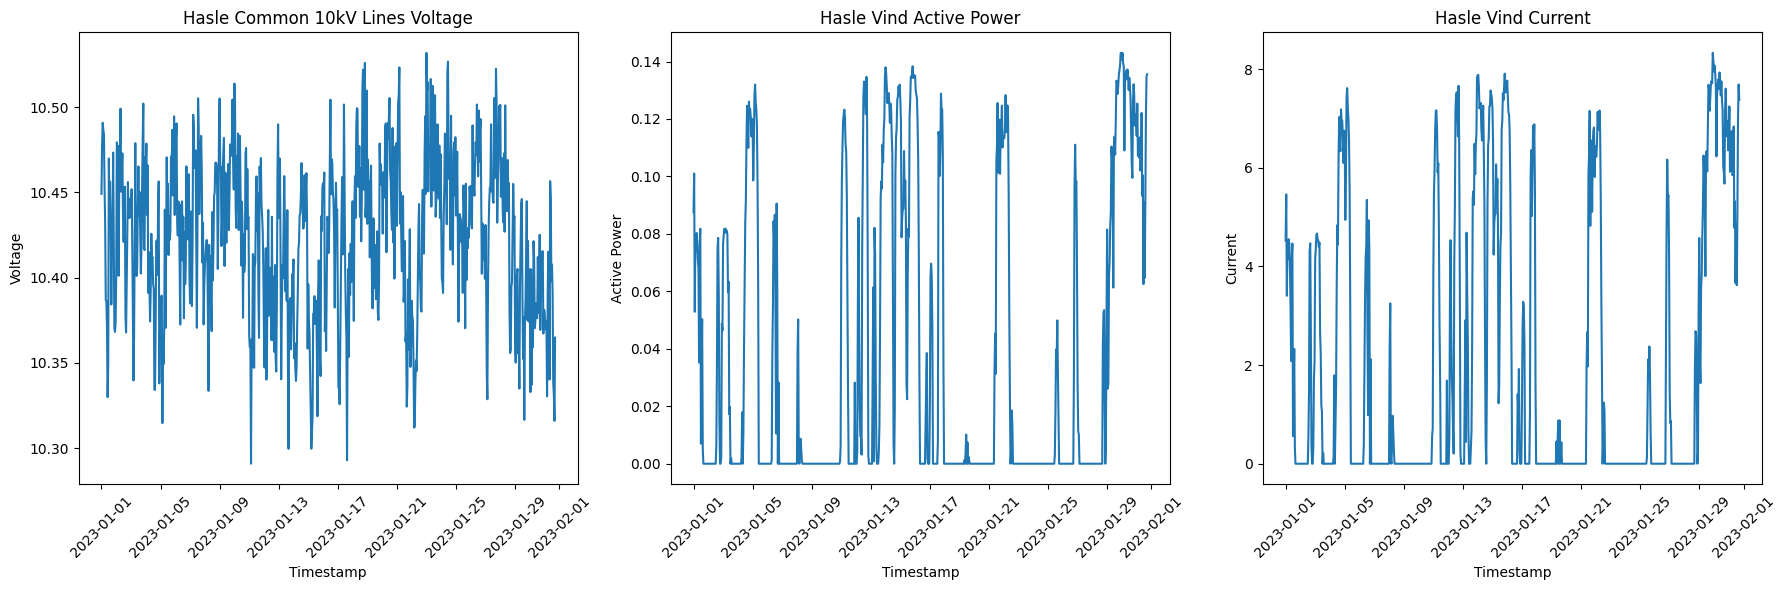

In [3]:
# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot each of the three features in separate subplots
sns.lineplot(data=network_manager_hourly, x='ts', y='Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133', ax=axes[0])
axes[0].set_title('Hasle Common 10kV Lines Voltage')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Voltage')

sns.lineplot(data=network_manager_hourly, x='ts', y='Hasle Vind Active Power | has_vin_effekt | 804123', ax=axes[1])
axes[1].set_title('Hasle Vind Active Power')
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Active Power')

sns.lineplot(data=network_manager_hourly, x='ts', y='Hasle Vind Current | has_vin_belastning | 804117', ax=axes[2])
axes[2].set_title('Hasle Vind Current')
axes[2].set_xlabel('Timestamp')
axes[2].set_ylabel('Current')

# Rotate ticks
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Nordpool Price**

In [ ]:
nordpool_price.head()

In [ ]:
# Plot hourly price over time
plt.figure(figsize=(12, 6))
plt.plot(nordpool_price.index, nordpool_price['Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038'])
plt.ylabel('Price (DKK/MWh)')
# plt.plot(nordpool_price.index, nordpool_price['Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820'])
# plt.ylabel('Price (€/MWh)')
plt.title('Nordpool Hourly Price')
plt.xlabel('Timestamp')

plt.xticks(rotation=45)
plt.show()


#### Data merge

In [4]:
# Merge the datasets on the 'ts' index
merged_data = network_manager_hourly.merge(nordpool_price, on='ts', how='inner')
merged_data = merged_data.merge(weather_forecast, on='ts', how='inner')
merged_data = merged_data.merge(weather_observation, on='ts', how='inner')
merged_data = merged_data.merge(energinet_price, on='ts', how='inner')

# Sort the data by the timestamp column 'ts' to ensure time order
merged_data.sort_values(by='ts', inplace=True)

# Define the feature columns (X) and the target column (y)
# For example, if 'Hasle Vind Active Power' is the target column
X = merged_data.drop(columns=['Hasle Vind Active Power | has_vin_effekt | 804123',
                              'HourDK | HourDK | 804695',
                              'HourUTC | HourUTC | 804694'])

y = merged_data['Hasle Vind Active Power | has_vin_effekt | 804123']

# Check the resulting merged data and features
merged_data.head()


,ts,Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133,Hasle Vind Active Power | has_vin_effekt | 804123,Hasle Vind Current | has_vin_belastning | 804117,Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038,Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820,Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270,Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286,Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318,Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302,...,mFRRUpActSpec | mFRRUpActSpec | 804713,mFRRDownActSpec | mFRRDownActSpec | 804714,ImbalanceMWh | ImbalanceMWh | 804715,ImbalancePriceEUR | ImbalancePriceEUR | 804716,ImbalancePriceDKK | ImbalancePriceDKK | 804717,BalancingPowerPriceUpEUR | BalancingPowerPriceUpEUR | 804718,BalancingPowerPriceUpDKK | BalancingPowerPriceUpDKK | 804719,BalancingPowerPriceDownEUR | BalancingPowerPriceDownEUR | 804720,BalancingPowerPriceDownDKK | BalancingPowerPriceDownDKK | 804721,mFRRUpActBal | mFRRUpActBal | 804722
0,2023-01-02 00:00:00,10.402319,0.0,0.0,57.91,430.65,221.196671,3.227234,2.425691,2.128321,...,0.0,0.0,41.299999,76.430000,568.349976,76.430000,568.349976,51.669998,384.229248,0.0
1,2023-01-02 01:00:00,10.479418,0.0,0.0,51.67,384.24,213.305710,2.602990,2.173800,1.431723,...,0.0,0.0,60.200001,85.629997,636.789978,85.629997,636.789978,52.860001,393.094940,0.0
2,2023-01-02 02:00:00,10.473787,0.0,0.0,52.86,393.09,200.907639,2.393477,2.235174,0.857204,...,0.0,0.0,79.000000,32.270000,240.000000,44.160000,328.428894,32.270000,240.000000,0.0
3,2023-01-02 03:00:00,10.477362,0.0,0.0,44.16,328.39,199.195374,2.512319,2.371845,0.828741,...,0.0,0.0,105.300003,50.080002,372.420013,50.080002,372.420013,50.080002,372.420013,0.0
4,2023-01-02 04:00:00,10.401084,0.0,0.0,50.08,372.42,174.695465,1.612934,1.606051,-0.146784,...,0.0,0.0,196.399994,70.730003,525.979980,70.730003,525.979980,70.730003,525.979980,0.0


In [ ]:
# Check missing values
print(merged_data.isnull().sum())

## Step 3

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [6]:
# Get shapes
print("Train set", X_train.shape)
print("Test set", X_test.shape)

Train set (565, 31)
Test set (142, 31)


In [7]:
# Assuming your data has a 'ts' column (time series or timestamp)
ts_column = X['ts']  # Extract the 'ts' column
price_Area = X['PriceArea | PriceArea | 804696']
X_features = X.drop(columns=['ts','PriceArea | PriceArea | 804696'])  # Remove 'ts' from features

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Split the data into training and testing sets (80% training, 20% testing)
# Perform a time series split: 80% for training, 20% for testing
split_index = int(0.8 * len(merged_data))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


X_train_df = pd.DataFrame(X_train, index=ts_column.index[:len(X_train)])
X_test_df = pd.DataFrame(X_test, index=ts_column.index[len(X_train):])

# Concatenate the 'ts' column to X_train and X_test
X_train = pd.concat([X_train_df, ts_column[:len(X_train)]], axis=1)
X_test = pd.concat([X_test_df, ts_column[len(X_train):]], axis=1)

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (565, 30)
Testing data shape: (142, 30)


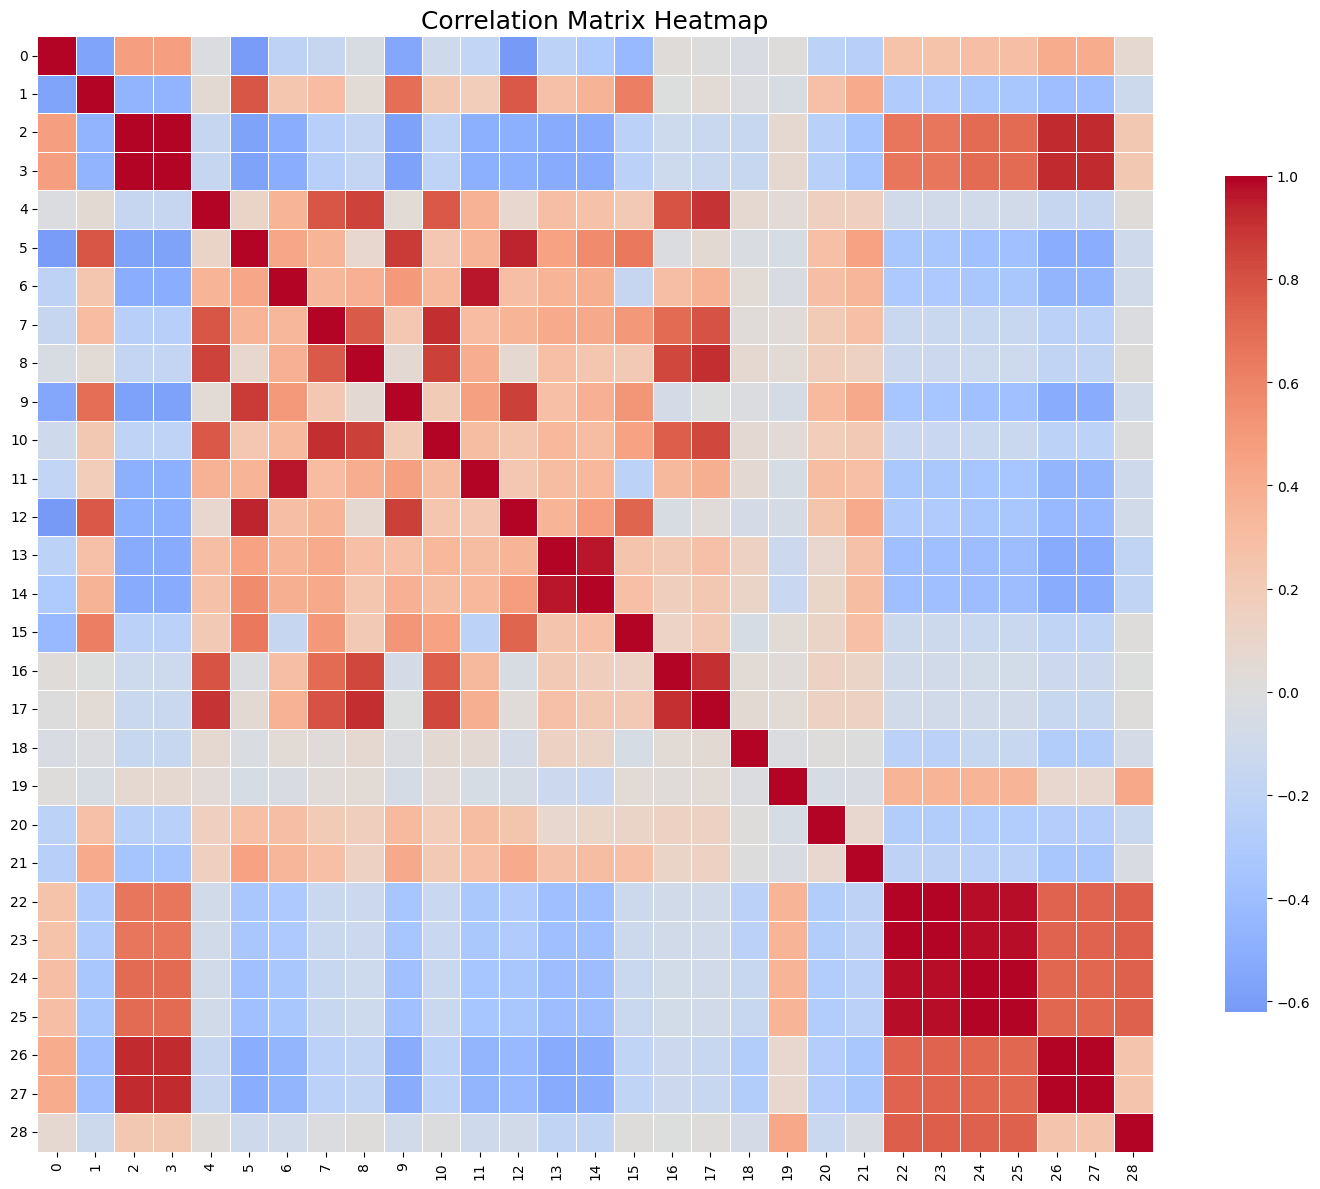

In [8]:
import seaborn as sns

# Correlation matrix between features
corr_matrix = X_train_df.corr()
# print(corr_matrix)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={"shrink": 0.75}, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=90)  # Rotate the feature names for better visibility
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


In [7]:
# # Search for the columns where '57,91' appears
# mask = merged_data.apply(lambda x: x.astype(str).str.contains('57,91'))

# # Find the columns that contain the value '57,91'
# problematic_columns = mask.any(axis=0)
# columns_with_issues = merged_data.columns[problematic_columns]

# # Print the column names
# print("Columns containing '57,91':")
# print(columns_with_issues)

In [9]:
# Step 3.1: Implementing Linear Regression with Gradient Descent in matrix form
class LinearRegressionGD:

    # attributes of the class
    def __init__(self, learning_rate=0.01, n_iterations=1000): 
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    # gradient descent algorithm
    def fit(self, X, y): 
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    # prediction function
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

# Step 3.1: Implementing the closed-form solution (Normal Equation)
def closed_form_solution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best


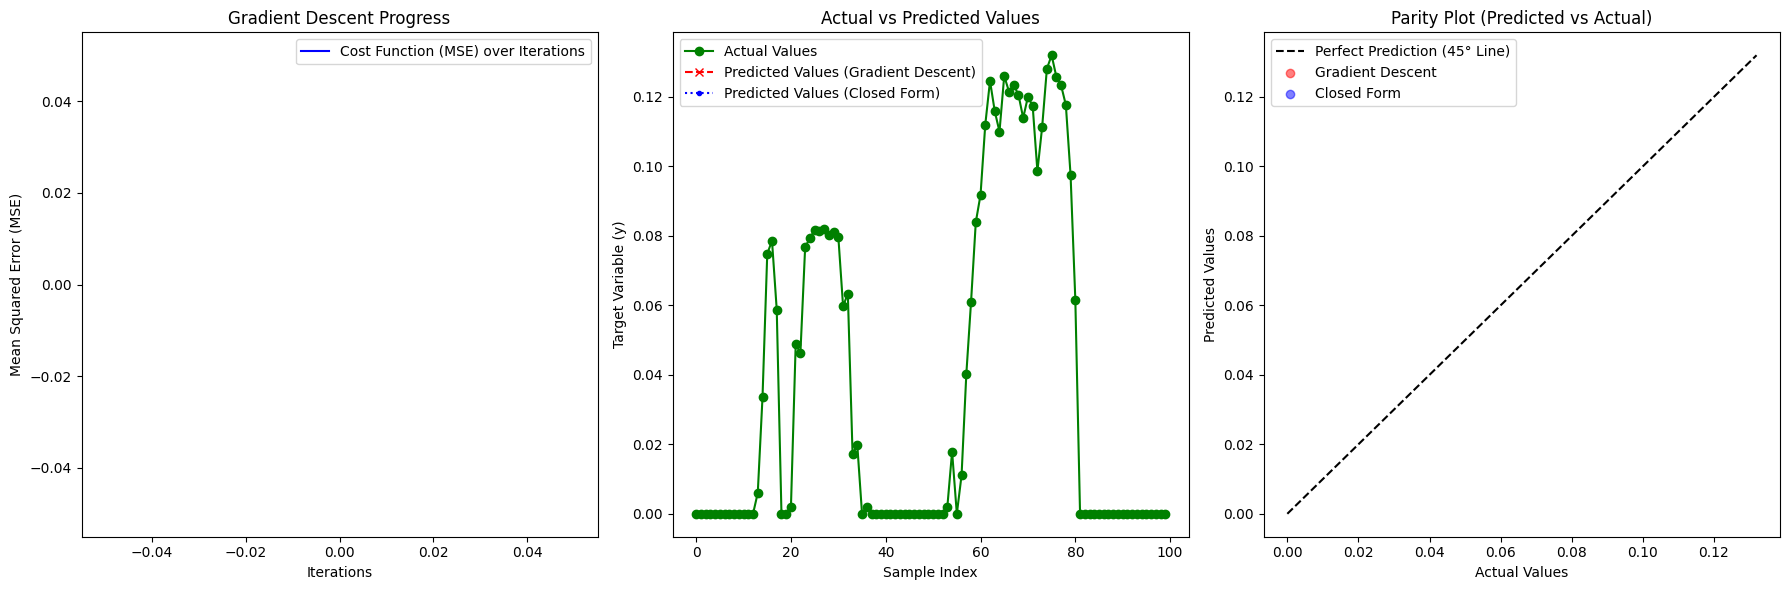

Gradient Descent Coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Closed-Form Solution Coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Are the predictions close?  False


In [10]:
# Step 3.1: Test on a small sample (e.g., first 100 rows)
X_train_small = np.array(X_train_df[:100], dtype=float)  # Ensure proper conversion
y_train_small = np.array(y_train[:100], dtype=float)  # Ensure proper conversion

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = closed_form_solution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train_small, label='Actual Values', marker='o', color='g')
axs[1].plot(y_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form))


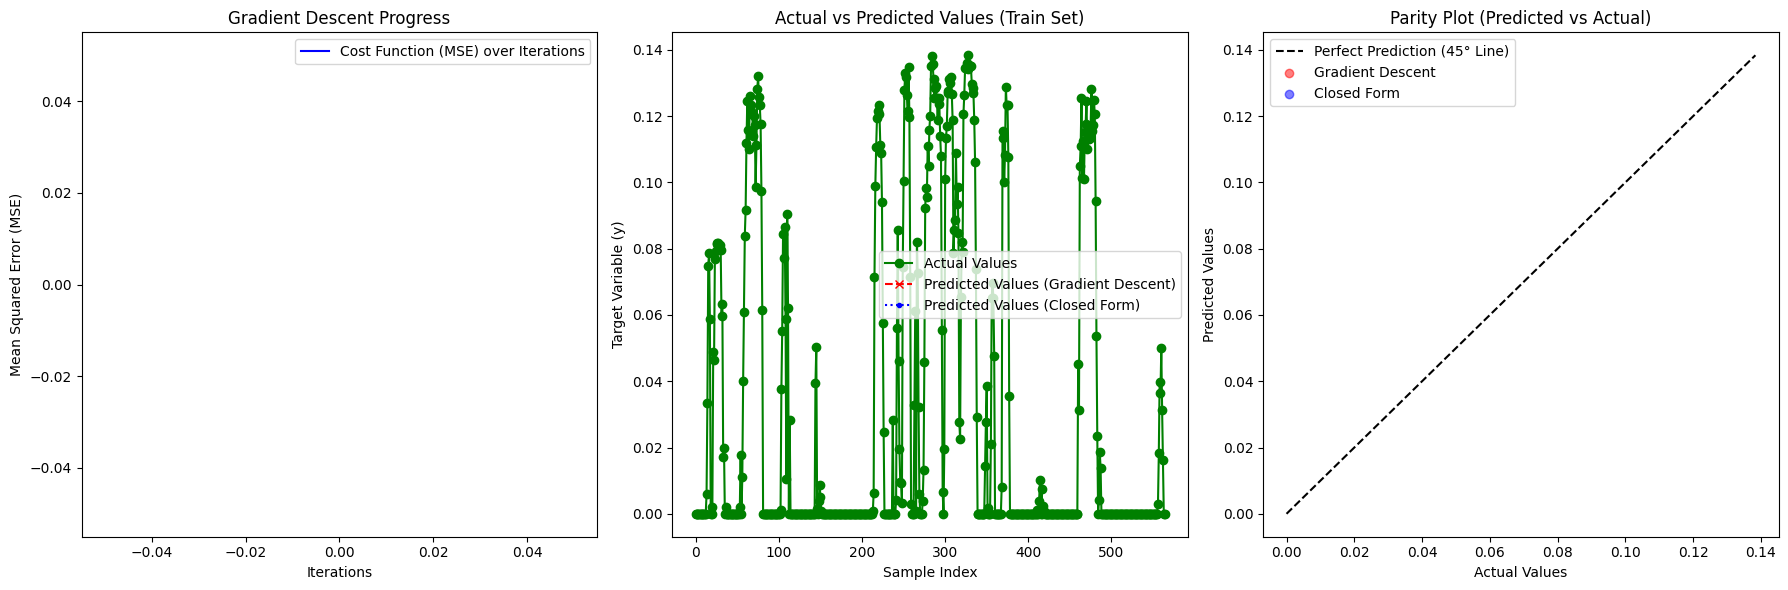

Gradient Descent Coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Closed-Form Solution Coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
Are the predictions close?  False


In [11]:
# Assuming X_train_df and y_train are defined and scaled already

# Closed-Form Solution (Normal Equation)
theta_best_full = closed_form_solution(X_train_df, y_train)
X_b_full = np.c_[np.ones((X_train_df.shape[0], 1)), X_train_df]
y_train_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)  # You can increase iterations if needed
gd_model.fit(X_train_df, y_train)
y_train_pred_gd = gd_model.predict(X_train_df)

# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[1].plot(y_train_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_train_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Train Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_closed_form.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')

# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_train, y_train_pred_gd, label='Gradient Descent', color='r', alpha=0.5)

# Scatter plot for Closed-Form predictions
axs[2].scatter(y_train, y_train_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_train_pred_gd, y_train_pred_closed_form))


In [12]:
# Step 3.3: Evaluate the model on the testing dataset
X_b_test = np.c_[np.ones((X_test.shape[0], 1)), X_test_df]
y_test_pred = X_b_test.dot(theta_best_full)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

ValueError: Input contains NaN.

## Step 4

In [ ]:
# Step 4.1: Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_df)

# Train the polynomial regression model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_train_pred_poly = model_poly.predict(X_train_poly)

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train_df.shape[0])  # Random weights for demonstration -> how to set up 
model_weighted = LinearRegression()
model_weighted.fit(X_train_df, y_train, sample_weight=weights)
y_train_pred_weighted = model_weighted.predict(X_train_df)

# Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_gd))
mae_linear = mean_absolute_error(y_train, y_train_pred_gd)
r2_linear = r2_score(y_train, y_train_pred_gd)

rmse_poly = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
r2_poly = r2_score(y_train, y_train_pred_poly)

rmse_weighted = np.sqrt(mean_squared_error(y_train, y_train_pred_weighted))
mae_weighted = mean_absolute_error(y_train, y_train_pred_weighted)
r2_weighted = r2_score(y_train, y_train_pred_weighted)

print(f"Linear Model RMSE: {rmse_linear}")
print(f"Polynomial Model RMSE: {rmse_poly}")
print(f"Weighted Model RMSE: {rmse_weighted}")


In [ ]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_train_pred_gd, label='Predicted (Linear Regression)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_train_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_train, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_train_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_train.min(), y_train_pred_gd.min(), y_train_pred_poly.min(), y_train_pred_weighted.min())
max_val = max(y_train.max(), y_train_pred_gd.max(), y_train_pred_poly.max(), y_train_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_train, y_train_pred_gd, color='b', alpha=0.5, label='Linear Regression')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_train, y_train_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_train, y_train_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Step6

#Getting Wind Forecast for target period by inserting the x data for the same period
WindProductionForecast = gd_model.predict(X_test_df)

#Loading the Spot and Balancing Prices needed for the optimization model
SpotPriceData = X_test_df.iloc[:,3]
BalancingUp = X_test_df.iloc[:,4]
BalancingDown = X_test_df.iloc[:,5]



#Loading the Actual Wind Production that is needed to calculate the optimal in hindsight decision
ActualWindProduction = y_test

#Defining the maximal possible bid by looking for the maximum production
NamePlateCapacity = max(y_test)

#Defining the number of hours that we bid based on the number of hours in the validation data set
NumberofHours = len(y_test)

#Defining the model

model = gp.Model("Wind Power Optimization")

#####################################Defining Variables of the model##################################################################

#Defining variable for the optimal bid in the day ahead market
DA_Bid = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="DA_Bid")

#Variable if the production was actually higher than what was bid on the day ahead market, this number will be sold on the balancing market
Balance_Up = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="Balance_Up")

#Variable if the production was actually lower than what was bid on the day ahead market, this deficit will be purchased on the balancing market
Balance_Down = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="Balance_Down")

#Variable that describes the delta between day ahead bid and actual production
Delta = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS,lb=-GRB.INFINITY, name="Delta")



#############################Defining the objective function#######################################################
objective = (
    gp.quicksum(SpotPriceData.iloc[h] * DA_Bid[h] for h in range(NumberofHours))
    + gp.quicksum(BalancingUp.iloc[h] * Balance_Up[h] for h in range(NumberofHours))
    - gp.quicksum(BalancingDown.iloc[h] * Balance_Down[h] for h in range(NumberofHours))
)
model.setObjective(objective, GRB.MAXIMIZE)

#########################Defining Constraints of model###########################################################

for h in range(NumberofHours):
    #Adding Constraint that defines delta as the difference between the day ahead bid and the actual power production. Delta is positive for overproduction, negative for underproduction
    model.addConstr(Delta[h] == WindProductionForecast[h] - DA_Bid[h], name=f"Defining Delta_{h}")
    #Adding constraint that defines the value for balance_up/down
    model.addConstr(Delta[h] == Balance_Up[h] - Balance_Down[h] , name=f"Defining Delta Up/Down_{h}")
    #Constraint that makes sure, that bid can´t be higher than the maximum capacity of the wind farm
    model.addConstr( DA_Bid[h] <= NamePlateCapacity, name=f"Production Capacity_{h}")

model.optimize()

if model.status == GRB.INFEASIBLE:
    print("Model is infeasible.")
elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded.")
elif model.status == GRB.TIME_LIMIT:
    print("Time limit reached.")
elif model.status == GRB.OPTIMAL:
    print("Optimal solution found.")
    TotalRevenue = model.objVal
    print("Total Revenue: ", TotalRevenue)

#Saving Day ahead bid as here and now decision

DA_BidValues = [DA_Bid[h].X for h in range(NumberofHours)]

##############Second Stage#############################
#First the actual production delta needs to be calculated based on the actual wind power production

ActualProductionDelta= []

for h in range(NumberofHours):
    ActualProductionDelta[h] = ActualWindProduction[h] - DA_Bid[h]

#Calculating the balancing cost based on the actual production delta and the balancing prices + total revenue by adding Day Ahead Revenue and BalancingMarket Revenue/Cost

BalancingCost= []
TotalRevenue= []

for h in range(NumberofHours):
    if ActualProductionDelta >0:
        BalancingCost[h] = ActualProductionDelta[h]*BalancingUp.iloc[h]
    else: 
        BalancingCost[h] = ActualProductionDelta[h]*BalancingDown.iloc[h]
    TotalRevenue[h] = DA_Bid[h]*SpotPriceData[h] + BalancingCost[h]

#########Optimal in Hindsight Solution##################
#It is the same model, but it takes the actual wind production as input in the objective function instead of forecasted values


        








## Model 2

In [28]:
def OptimalinHindsightModel (merged_data):
   
    #Loading the data
    SpotPriceData = merged_data.loc[:,'Nordpool Elspot Prices - hourly price DK-DK2 EUR/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_eur | 3038']
    WindProduction = merged_data.loc[:,'Hasle Vind Active Power | has_vin_effekt | 804123']
    DeficitproductionPrice = merged_data.loc[:,'BalancingPowerPriceUpEUR | BalancingPowerPriceUpEUR | 804718']
    OverProductionPrice = merged_data.loc[:,'BalancingPowerPriceDownEUR | BalancingPowerPriceDownEUR | 804720']

    #Defining the maximal possible bid by looking for the maximum production. Multiplying by 1000 assuming the data is given in GW
    NamePlateCapacity = max(WindProduction)*1000
    #Defining the number of hours that we bid based on the number of hours in the wind production set
    NumberofHours = len(WindProduction)


    #Defining the model

    model = gp.Model("Wind Power Optimization")

    #####################################Defining Variables of the model##################################################################

    #Defining variable for the optimal bid in the day ahead market
    DA_Bid = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="DA_Bid")

    #Variable if the production was actually higher than what was bid on the day ahead market, this number will be sold on the balancing market
    Balancing_Surplus = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="Balancing_Surplus")

    #Variable if the production was actually lower than what was bid on the day ahead market, this deficit will be purchased on the balancing market
    Balancing_Deficit = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS, name="Balancing_Deficit")

    #Variable that describes the delta between day ahead bid and actual production
    Delta = model.addVars(NumberofHours, vtype=GRB.CONTINUOUS,lb=-GRB.INFINITY, name="Delta")



    #############################Defining the objective function#######################################################
    objective = (
        gp.quicksum(SpotPriceData.iloc[h] * DA_Bid[h] for h in range(NumberofHours))
        + gp.quicksum(OverProductionPrice.iloc[h] * Balancing_Surplus[h] for h in range(NumberofHours))
        - gp.quicksum(DeficitproductionPrice.iloc[h] * Balancing_Deficit[h] for h in range(NumberofHours))
    )
    model.setObjective(objective, GRB.MAXIMIZE)

    #########################Defining Constraints of model###########################################################

    for h in range(NumberofHours):
        #Adding Constraint that defines delta as the difference between the day ahead bid and the actual power production. Delta is positive for overproduction, negative for underproduction
        model.addConstr(Delta[h] == WindProduction[h]*1000 - DA_Bid[h], name=f"Defining Delta_{h}")
        #Adding constraint that defines the value for balance_up/down
        model.addConstr(Delta[h] == Balancing_Surplus[h] - Balancing_Deficit[h] , name=f"Defining Delta Up/Down_{h}")
        #Constraint that makes sure, that bid can´t be higher than the maximum capacity of the wind farm
        model.addConstr( DA_Bid[h] <= NamePlateCapacity, name=f"Production Capacity_{h}")

    model.optimize()

    if model.status == GRB.INFEASIBLE:
        print("Model is infeasible.")
    elif model.status == GRB.UNBOUNDED:
        print("Model is unbounded.")
    elif model.status == GRB.TIME_LIMIT:
        print("Time limit reached.")
    elif model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
        TotalRevenue = model.objVal
        print("Total Revenue: ", TotalRevenue)
        DA_BidValues = [DA_Bid[h].X for h in range(NumberofHours)]

    

    return pd.Series(DA_BidValues)



In [29]:
DA_BidValues= OptimalinHindsightModel (merged_data)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2121 rows, 2828 columns and 4242 nonzeros
Model fingerprint: 0xc7a07a7b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 7e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve removed 2038 rows and 2579 columns
Presolve time: 0.01s
Presolved: 83 rows, 249 columns, 249 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8318240e+34   7.900000e+31   3.831824e+04      0s
     162    1.9111256e+06   0.000000e+00   0.000000e+00      0s

Solved in 162 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.911125614e+06
Optimal solution found.
Total Revenue:  1911125.6141968456
